In [207]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from sklearn.metrics import roc_curve
import torch
from torch.autograd import Variable
matplotlib.rcParams.update({'font.size': 18})

In [89]:
protected_var = 'sex'
if protected_var == 'sex':
  protected_var_categories = ['Male', 'Female']
elif protected_var == 'race':
  protected_var_categories = ['White', 'Black', 'Asian', 'American-Indian', 'Other']
elif protected_var == 'age':
  protected_var_categories = ['0-18', '18-25', '25-30', '30-35', '35-40', '40-45', '45-50',
                              '50-55', '55-60', '60-65', '65+']

In [90]:
# Data paths
path = 'data/adult/'
X_name = path + 'X_valid.pkl' # CHANGE TO VAL
y_name = path + 'y_valid.pkl'
z_name = path + protected_var + '_valid.pkl'

In [91]:
# Load data
def load_data(fname):
  data = pd.read_pickle(fname)
  return data.values, Variable(torch.tensor(data.values).float())

X, X_tensor = load_data(X_name)
y, y_tensor = load_data(y_name)
z, z_tensor = load_data(z_name)

In [131]:
# Model paths
path = 'logs/adult/'
alpha_names = []
# alphas = ['0.1', '0.5', '1', '1.5', '2.5', '5', '7.5', '10']
alphas = ['1', '900']
for alpha in alphas:
  alpha_names.append(path + protected_var + '-odds-alpha-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10-n_h_adv_10-dropout_rate_0.5-alpha_' \
    + alpha + '-model.pth')
  
basic_model_name = path + 'basic-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10--dropout_rate_0.5--model.pth'
odds_model_name = path + protected_var + '-odds-alpha-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10-n_h_adv_10-dropout_rate_0.5-alpha_300-model.pth'
parity_model_name = path + protected_var + '-parity-alpha-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10-n_h_adv_10-dropout_rate_0.5-alpha_10-model.pth'

In [132]:
# Load models
def load_model(fname):
  model = torch.load(fname)
  model.eval()
  return model

basic_model = load_model(basic_model_name)
odds_model = load_model(odds_model_name)
parity_model = load_model(parity_model_name)
alpha_models = {}
for i, alpha in enumerate(alphas):
  alpha_models[alpha] = load_model(alpha_names[i])

/Users/justinchen/miniconda3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


# 

In [133]:
def get_roc(model):
  ypred = model(X_tensor).data.numpy().squeeze()
  curves = []
  for i in range(len(protected_var_categories)):
    curves.append(roc_curve(y[z == i], ypred[z == i]))
  return curves
  
basic_roc = get_roc(basic_model)
odds_roc = get_roc(odds_model)
parity_roc = get_roc(parity_model)
alpha_rocs = {}
for alpha in alpha_models:
  alpha_rocs[alpha] = get_roc(alpha_models[alpha])

In [208]:
colors = ['teal', 'lightcoral']
colors2 = ['darkblue', 'darkred']

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def plot_roc(curves, ax, model_type, xrange=None, yrange=None):
  for i, curve in enumerate(curves):
    fpr, tpr, thresholds = curve
    idx_thresh = find_nearest(thresholds, .5)
    ax.scatter(fpr[idx_thresh], tpr[idx_thresh], marker='x', s=400, c=colors2[i], linewidth=4)
    ax.plot(fpr, tpr, label = model_type + ': ' + protected_var_categories[i],
           c=colors[i], linewidth=3)
  ax.set_xlabel('False positive rate')
  ax.set_ylabel('True positive rate')
  ax.legend(loc=2)
  if xrange is not None:
    ax.set_xlim(xrange[0], xrange[1])
  if yrange is not None:
    ax.set_ylim(yrange[0], yrange[1])

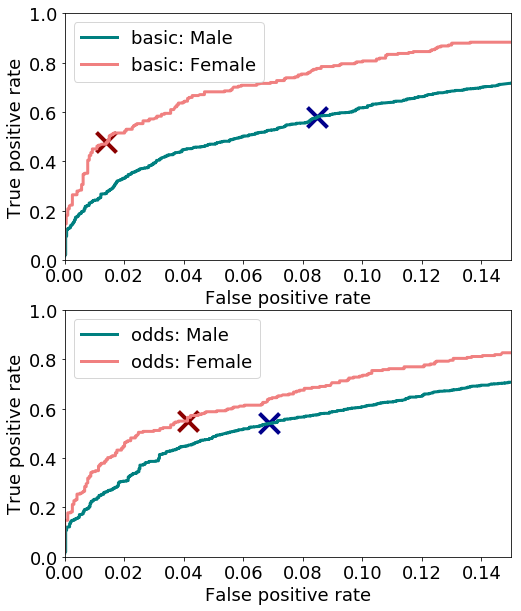

In [209]:
xrange = [0, 0.15]
yrange = [0, 1]
fig, axes = plt.subplots(2, 1, figsize=(8,10))
# Plot 1
def plot_compare(roc, row, name):
  plot_roc(roc, axes[row], name, xrange=xrange, yrange=yrange)
  
plot_compare(basic_roc, 0, 'basic')
plot_compare(odds_roc, 1, 'odds')

In [193]:
#To do: Make plot of threshold vs acc and tp / fp rates for equality of opportunity